In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def sample_normal_distribution(var):
    """
    Sample normal distribution with variance = var
    """
    rand = np.random.uniform(low=-1.0, high=1.0, size=12)
    return var * np.sum(rand) / 6


def prob_normal_distribution(x, var):
    """
    Calculate value of PDF of p(X = x) given X having normal distribution
    """
    return np.exp(-x**2 / (2 * var)) / np.sqrt(2 * np.pi * var)

In [3]:
def motion_model(x, u):
    """
    Noise-free motion model
    Input:
        x (np.ndarray) - shape (3,1) : robot location in 3D space
        u (np.ndarray) - shape (3,1) : motion command (robot velocities)
    Output:
        xt (np.ndarray) - shape (3,1) : new robot location
    """
    return x + u * delta_t
    

def measurement_model(x, m):
    """
    Noise-free measurement model given state x (robot loc.) & map m
    Input:
        x (np.ndarray) - shape (3,1) : robot location in 3D space
        m (np.ndarray) - shape (num_beacons,3) : location of all beacons in the map
    Output:
        z (np.ndarray) - shape (num_beacons,) : distance from robot to each beacons
    """
    return np.sqrt(np.sum((m - x.squeeze())**2, axis=1))


def simulation_step(x, u):
    """
    Perform 1 step of simulation
    Input:
        x (np.ndarray) - shape (3,1) : robot location in 3D space
        u (np.ndarray) - shape (3,1): motion command (robot velocities)
    Output:
        xt (np.ndarray) - shape (3,1) : new robot location
        zt (np.ndarray) - shape (num_beacons,) : measurement at new location
    """
    # Perturb motion command
    u_noise = np.array([sample_normal_distribution(var_v) for i in range(3)])
    u_hat = u + u_noise.reshape(-1, 1)
    
    # Compute new location
    xt = motion_model(x, u_hat)  # here xt is the ground truth of robot location
    
    # Compute expected value of measurement
    zt_bar = measurement_model(xt, m) 
    # Perturb measurement
    zt = zt_bar + np.array([sample_normal_distribution(var_z) for i in range(num_beacons)])
    
    return xt, zt

In [4]:
def prob_measurement_model(zt, xt, m):
    """
    Probability of measurement zt conditioned on state xt & map m
    Input:
        zt (np.ndarray) - shape (num_beacons,) : latest measurement
        xt (np.ndarray) - shape (3,1) : current robot location in 3D space
        m (np.ndarray) - shape (num_beacons,m) : location of all beacons in the map
    Return
        p(zt | xt, m) - scalar
    """
    # calculate expected measurement
    z_hat = measurement_model(xt, m)
    # measurement noise
    noise = zt - z_hat
    # probability of measurement
    prob = 1.
    for i in range(num_beacons):
        prob *= prob_normal_distribution(noise[i], var_z)
    return prob

In [5]:
def sample_motion_model(ut, x_tm1):
    """
    Sample new pose from motion model given action ut & current pose x_tm1
    Input:
        xt (np.ndarray) - shape (3,1) : current robot location in 3D space
        ut (np.ndarray) - shape (3,1): motion command (robot velocities)
    """
    # Perturb motion command
    u_noise = np.array([sample_normal_distribution(var_v) for i in range(3)])
    u_hat = ut + u_noise.reshape(-1, 1)
    
    # Compute new location
    xt = motion_model(x_tm1, u_hat)  # here xt is the ground truth of robot location
    return xt

In [6]:
def low_variance_sampler(Xt, Wt):
    """
    Sample set of particles Xt w.r.t importance factor Wt
    Input:
        Xt (list): each element is a particle
        Wt (list): each element is a scaler represents an importance factor
    Return:
        Xt_bar (list): sampled set of particle
    """
    Xt_bar = []
    M = len(Xt)  # number of particles
    r = np.random.uniform(0, 1. / M)
    c = Wt[0]
    i = 0
    for m in range(M):
        u = r + m * 1. / M
        while u > c:
            i += 1
            c += Wt[i]
        Xt_bar.append(Xt[i])
    return Xt_bar

In [7]:
def monte_carlo_localization(X_tm1, ut, zt, m):
    """
    Implementation of Monte Carlo Algorithm
    Input:
        X_tm1 (list): each element is a particle
        ut (np.ndarray) - shape (3,1): motion command (robot velocities)
        zt (np.ndarray) - shape (num_beacons,) : latest measurement
        m (np.ndarray) - shape (num_beacons,m) : location of all beacons in the map
    Output:
        X_t (list): each element is a particle
    """
    Xt_bar = []
    Wt = []
    for x_tm1 in X_tm1:
        # sample particle with motion model
        xt = sample_motion_model(ut, x_tm1)
        # importance factor
        wt = prob_measurement_model(zt, xt, m)
        # store particle & importance factor
        Xt_bar.append(xt)
        Wt.append(wt)
    # Normalize Wt  -- this step is needed for low_variance_resampling (otherwise wt is too small)
    Wt = np.array(Wt)
    Wt /= np.sum(Wt)
    # resampling
    Xt = low_variance_sampler(Xt_bar, Wt)
    return Xt

In [8]:
# CONSTANT
a = 5.  # size of the environment

# feature-based map --> list of beacons coordinate
m = np.array([[0., 0., 0.],
              [a, 0., 0.],
              [a, a, a],
              [0., a, a]])  # each row defines 1 beacon
num_beacons = m.shape[0]

var_v = 1.  # m^2/s^2
var_z = 1.  # m^2

delta_t = 0.25  # sec

In [9]:
# initialize
t = 0
x_true = np.zeros((3, 1)) 

# Initialize set of particle
M = 200 # number of particle
x_arr = np.random.uniform(0, a, size=M)
y_arr = np.random.uniform(0, a, size=M)
z_arr = np.random.uniform(0, a, size=M)

X_tm1 = [np.array([x, y, z]).reshape(3, 1) for x, y, z in zip(x_arr, y_arr, z_arr)]
print("Prior shape: ", len(X_tm1))

u = np.array([[0.5, 0., 0.5]]).T  # keep constant for the whole trajectory

ground_truth = [x_true.reshape(1, -1)]
local_re = [X_tm1]
time = []

# main loop
while t < 5.:
    # advance simulation 1 step 
    x_true, zt = simulation_step(x_true, u)
    
    # estimate new location
    X_t = monte_carlo_localization(X_tm1, u, zt, m)
    
    # store ground truth & estimate
    ground_truth.append(x_true.reshape(1, -1))
    local_re.append(X_t)
    time.append(t)
    
    # update 
    t += delta_t
    X_tm1 = X_t

Prior shape:  200


In [10]:
ground_truth = np.vstack(ground_truth)

In [11]:
ground_truth[-1]

array([2.16891201, 0.52137022, 2.28124972])

In [12]:
belief = []
color = []
for i, Xt in enumerate(local_re):
    particles_set = [x.reshape(1, -1) for x in Xt]
    particles_set = np.vstack(particles_set)
    belief.append(particles_set)
    color.append([i for j in range(particles_set.shape[0])])

Text(0.5, 0, 'z(m)')

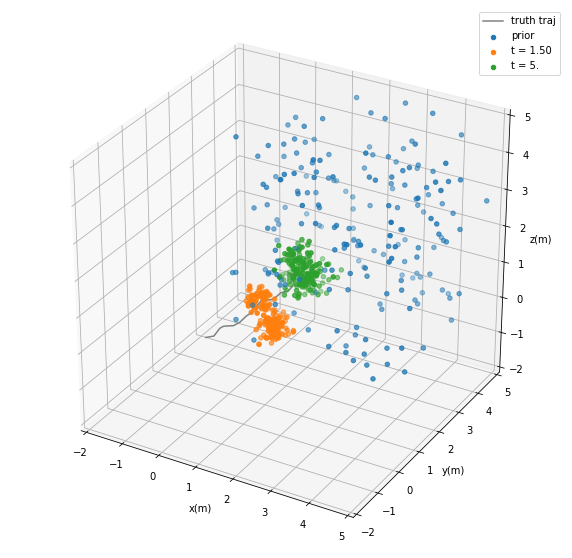

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2], 'gray', label='truth traj')
ax.scatter3D(belief[0][:, 0], belief[0][:, 1], belief[0][:, 2], label='prior')
ax.scatter3D(belief[6][:, 0], belief[6][:, 1], belief[6][:, 2], label='t = %.2f'%time[6])
ax.scatter3D(belief[-1][:, 0], belief[-1][:, 1], belief[-1][:, 2], label='t = 5.')
plt.legend()
ax.set_xlim([-2., a])
ax.set_ylim([-2., a])
ax.set_zlim([-2., a])
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.set_zlabel('z(m)')